In [279]:
import numpy as np
from dl import queryClient as qc, authClient as ac
from getpass import getpass
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from tqdm import tqdm_notebook
import statistics 
from astropy.io import fits 
import random

%matplotlib notebook

In [281]:
#--------------------------------------
# Get token from NOAO datalab
#--------------------------------------
try:
    input = raw_input
except NameError:
    pass
token = ac.login(input("Enter user name: "),getpass("Enter password: "))
if not ac.isValidToken (token):
    print ('nnnnnope (%s)' % token)
else:
    print ("Login token:   %s" % token)

Enter user name: katiefasbender
Enter password: ········
Login token:   katiefasbender.1579.1579.$1$jhF.53l2$51rQiEieDElzi.c.IQw8v1


In [282]:
def plot_dbscan(X,db,pltt,q=[]): #pltt=plt if plotting alone

    labels = db.labels_ #list of object's cluster labels; -1 = outlier
    core_samples_mask = np.zeros_like(labels, dtype=bool) #returns array of zeros of length len(labels)
    core_samples_mask[db.core_sample_indices_] = True #if object is core sample,make it "True" instead of "False"
    unique_labels=set(labels) #unique cluster labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # give each cluster a color, black is removed and used for noise.
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(10,10))
    
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        mark='o'
         
        if k == -1:
            col = [0, 0, 0, 0]
            mark='.'
        
        xy = X[class_member_mask & ~core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], mark, markerfacecolor=tuple(col),markersize=8,markeredgecolor=(0,0,0,0))
        
        xy = X[class_member_mask & core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], mark, markerfacecolor=tuple(col),markersize=8,markeredgecolor=(0,0,0,0),label=k)
    
    if q==1:
        pltt.legend(title='Clusters')
    #pltt.ticklabel_format(axes='both',useOffset=False)
    
    if pltt==plt:
        pltt.title('1$^{st}$ DBSCAN, %d Clusters,  %d Outliers' % (n_clusters,n_noise),size='xx-large')
        #plt.xlabel('RA[$^{\circ}$]')
        plt.ylabel('DEC[$^{\circ}$]')
    else: 
        pltt.set_title('1$^{st}$ DBSCAN, %d Clusters,  %d Outliers' % (n_clusters,n_noise),size='xx-large')
        #pltt.set_xlabel('RA[$^{\circ}$]')
        #pltt.set_ylabel('DEC')

In [283]:
def ranslap(cluster,out_table): #RANSAC on ra&dec, ra&mjd, dec&mjd, also gets v_ra, v_dec 
   
    ra=np.array(cluster['ra'])
    dec=np.array(cluster['dec'])
    Xra=np.reshape(ra,(len(ra),1))
    Xdec=np.reshape(dec,(len(dec),1))
    y=np.array(cluster['mjd'])

    #if max(y)-min(y)==0:
   # print(np.unique(y))
    if len(np.unique(y))<3:
        inlier_mask=np.zeros(len(ra), dtype=bool)
        #print("inlier mask = ",inlier_mask)
        outlier_mask=np.ones(len(ra), dtype=bool)
        clu_t=cluster[inlier_mask] #cluster inliers
        clu_s=clu_t
        no_t=cluster[outlier_mask] #cluster outliers
        no_s=no_t
        return(clu_t,no_t,0,0,clu_s,no_s) #keeps cluster as is, does not ransac it but gives all members outlier labels
    else:
# Robustly fit linear model with RANSAC algorithm-----------------------------------------
        ransac_ra = linear_model.RANSACRegressor(residual_threshold=.001)
        ransac_ra.fit(Xra, y)
        
        ransac_dec = linear_model.RANSACRegressor(residual_threshold=.001)
        ransac_dec.fit(Xdec, y)
        
        ransac_s = linear_model.RANSACRegressor(residual_threshold=.001)
        ransac_s.fit(Xra, Xdec)

# Predict data of estimated models--------------------------------------------------------
        line_Xra = np.reshape(np.arange(Xra.min(), Xra.max()+.0001,step=((Xra.max()+.0001)-Xra.min())/20),(20,1))
        line_y_ransac_ra = ransac_ra.predict(line_Xra) #line for RANSAC fit, ra
        
        line_Xdec = np.reshape(np.arange(Xdec.min(), Xdec.max()+.0001,step=((Xdec.max()+.0001)-Xdec.min())/20),(20,1))
        line_y_ransac_dec = ransac_dec.predict(line_Xdec) #line for RANSAC fit, dec
    
        xsra=np.concatenate(line_Xra)
        xsdec=np.concatenate(line_Xdec)
        ysra=line_y_ransac_ra
        ysdec=line_y_ransac_dec
        
        mra = (ysra[-1]-ysra[0])/(xsra[-1]-xsra[0])
        mdec = (ysdec[-1]-ysdec[0])/(xsdec[-1]-xsdec[0])
        
        inlier_mask_t = ransac_ra.inlier_mask_
        #print("inlier mask = ",inlier_mask)
        outlier_mask_t = np.logical_not(inlier_mask_t)
        clu_t=cluster[inlier_mask_t] #cluster after outlier removal (cluster inliers)
        no_t=cluster[outlier_mask_t] #cluster outliers
        
        inlier_mask_s = ransac_s.inlier_mask_
        #print("inlier mask = ",inlier_mask)
        outlier_mask_s = np.logical_not(inlier_mask_s)
        clu_s=cluster[inlier_mask_s] #cluster after outlier removal (cluster inliers)
        no_s=cluster[outlier_mask_s] #cluster outliers
        
        if mra!=0 and mdec!=0:
            return (clu_t,no_t,1/mra,1/mdec,clu_s,no_s)  #This is the velocity of the object that the tracklet (cluster) represents in ra & dec directions
        else:
            return(clu_t,no_t,0,0,clu_s,no_s)

# Get the data 

We have two options - use a healpix, or query with different radii

In [284]:
hdul=fits.open("vel_lim_test_data.fits") #open a fits file
dat_m=hdul[1].data #the data inside
rad=dat_m['cluster_label']==-1 #select all points not associated with a tracklets
rat=dat_m[rad]['ra'] #ra of rad points 
dect=dat_m[rad]['dec'] #dec of rad points
dates=dat_m[rad]['mjd']
ids=dat_m[rad]['measid']
cra=min(rat)+(max(rat)-min(rat))/2  #ra of center of healpix
cdec=min(dect)+(max(dect)-min(dect))/2 #dec of center of healpix
ave_time=min(dates)+(max(dates)-min(dates))/2

#--------------------------------------
# Create a random tracklet!
#--------------------------------------
def tracklet_creator(cra,cdec,ave_time,v_ra,v_dec,num,noise): 
    #{cra,cdec}=center (ra,dec) of hp [deg], 
    #{ave_time}=average exposure time [mjd], 
    #{v_ra,v_dec}=velocity of tracklet in ra,dec [deg/day], 
    #{num}=the fake tracklet # (how many have you put in so far? add one to that number.)
    #{noise}=True if you want noise, False if not.

    m=1 #this is a marker that tells the code later on that the tracklet still needs to be made/perfected
    while m==1:
        
#-------------------
# Set tracklet location 
#-------------------
        addition_ra=np.random.random_sample()*0.3 #distance between tracklet center and cra,cdec
        addition_dec=np.random.random_sample()*0.3
        tester_ra=bool(random.getrandbits(1)) #get a random true/false bit for ra and... 
        tester_dec=bool(random.getrandbits(1)) #...dec
        if tester_ra==True: #if the random bit is true,
            tra=cra+addition_ra #center ra of tracklet location (add the ra distance between hp center and tracklet center)
        else: #if the random bit is false,
            tra=cra-addition_ra #center ra of tracklet location (subtract the distance)
        if tester_dec==True:
            tdec=cdec+addition_dec #center dec of tracklet location (add the dec distance)
        else:
            tdec=cdec-addition_dec #center dec of tracklet location (subtract the distance)
#-------------------
# Set tracklet parameters (# measurements, time btw. measurements, measurement positions&times&ids) 
#-------------------          
        length=np.random.randint(3,10,size=1) #number of "measurements"
        time=(np.random.random_sample()*0.3)/24 #time increments between exposures (was just total elapsed time)
        d_ra=v_ra*float(time) #the distance traveled in ra in time increment
        d_dec=v_dec*float(time) #the distance traveled in dec in time increment
        #theta=np.random.randint(0,360,size=1) #orientation angle from right horizontal 
        ##points=np.column_stack((np.linspace(0,1,num=length),np.zeros(length))) #some pionts to make the tracklet
        #R = np.matrix([[np.cos(theta[0]),-np.sin(theta[0])],[np.sin(theta[0]),np.cos(theta[0])]]) #rotation matrix
        #rotated_points=[]
        tracklet_ras=[] #create empty  arrays to store tracklet measurement info
        tracklet_decs=[]
        tracklet_times=[]
        tracklet_ids=[]
        for i in range(0,int(length)): #for each tracklet measurement,
            tracklet_ras.append(tra+(i*d_ra)) #add ra, dec, obs_time, measid
            tracklet_decs.append(tdec+(i*d_dec))
            tracklet_times.append((ave_time+(i*(time))))
            tracklet_ids.append("%i_%s" %(num,str(i)))
            n=0 #a marker to help check whether tracklet is outside of our healpix
            if pow((pow((tracklet_ras[i]-cra),2)+pow((tracklet_decs[i]-cdec),2)),0.5)>0.25: #if a tracklet piont is outside,
                n=n+1 #increase n
            if n==0: #if points are NOT outside the healpix,
                m=0 #you're done making the tracklet
            else: #if points ARE outside the healpix,
                m=1 #you gotta make a new tracklet in a different location 
        #rotated_points.append(np.array(np.dot(R,[i[0],i[1]])))
        #rot=np.stack(rotated_points,axis=-1)
        #tracklet_ras=(rot[0][0]*d_ra)+tra
        #tracklet_decs=(rot[0][1]*d_dec)+tdec
#-------------------
# Determine distance between any two consecutive measurements  
#-------------------
    d_btwn=pow(pow((tracklet_ras[1]-tracklet_ras[0]),2)+pow((tracklet_decs[1]-tracklet_decs[0]),2),0.5)
#-------------------
# Add noise if requested
#-------------------
    if noise==True: #if you decide to put some noise in,
        num_noise=np.random.randint(1,10,size=1) #come up with random number of noise points to put in
        for i in range(0,len(num_noise)): #for every noise point,
            tracklet_ras.append(tra+(np.random.randint(0,10)*d_ra)) #add a random ra close to tracklet 
            tracklet_decs.append(tdec+(np.random.randint(0,10)*d_dec)) #add a random dec close to tracklet
            tracklet_times.append((ave_time+(np.random.randint(0,100)*(time)))) #add a random time that does not line up with tracklet
            tracklet_ids.append("%i_%s" %(num,str(99.99))) #measurement id is num_99.99 
        noise_marker=1
    else:
        noise_marker=0
    return(tracklet_ras,tracklet_decs,tracklet_times,tracklet_ids,d_btwn,noise_marker)

<IPython.core.display.Javascript object>


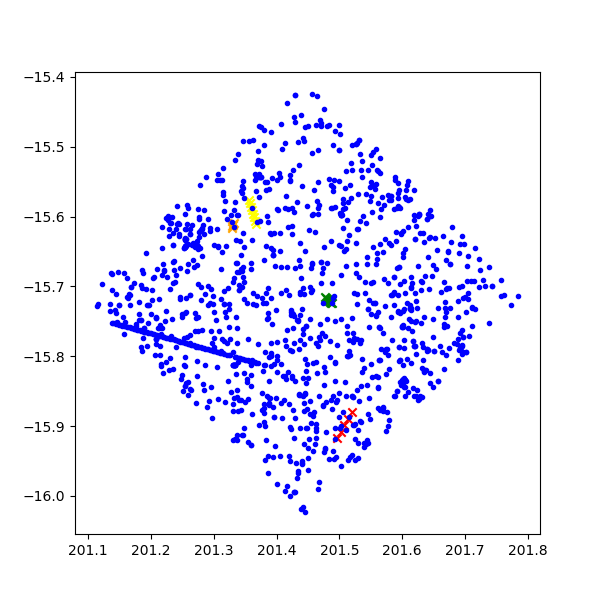

In [291]:
j1=tracklet_creator(201.35,-15.74,ave_time,0.5,0.8,0,False)
j2=tracklet_creator(201.35,-15.74,ave_time,0.2,0.4,0,False)
j3=tracklet_creator(201.35,-15.74,ave_time,-0.3,0.9,0,False)
j4=tracklet_creator(201.35,-15.74,ave_time,0.7,-0.6,0,False)
plt.figure(figsize=(6,6))
plt.scatter(j1[0],j1[1],marker='x',c="red")
plt.scatter(j2[0],j2[1],marker='x',c="orange")
plt.scatter(j3[0],j3[1],marker='x',c="yellow")
plt.scatter(j4[0],j4[1],marker='x',c="green")
plt.scatter(rat,dect,marker='.',c="blue")
plt.show()

<IPython.core.display.Javascript object>


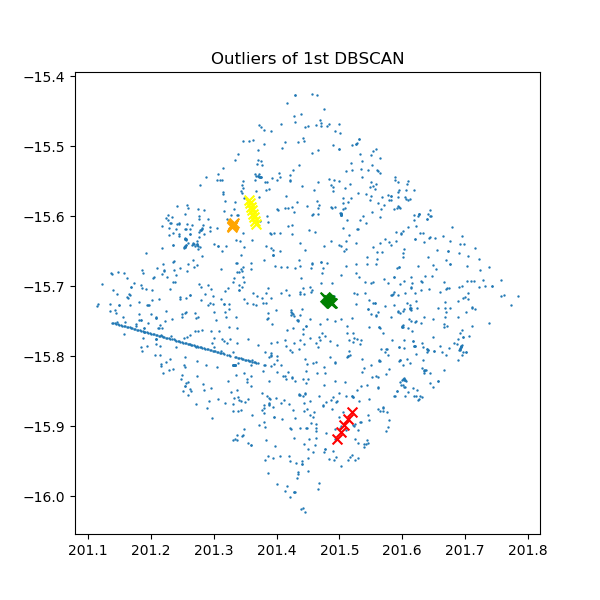

In [293]:
#query from nsc measurements list-----------------------------------------------------------------------------------
X=np.column_stack((rat,dect))
db = DBSCAN(eps=0.000138889, min_samples=2).fit(X)  #eps= 0.000138889 degrees and min_samples= 2  
dooutliers=db.labels_==-1
plt.figure(figsize=(6,6))
plt.title("Outliers of 1st DBSCAN")
plt.scatter(rat[dooutliers],dect[dooutliers],s=0.5)
plt.scatter(j1[0],j1[1],c='red',s=50,marker='x')
plt.scatter(j2[0],j2[1],c='orange',s=50,marker='x')
plt.scatter(j3[0],j3[1],c='yellow',s=50,marker='x')
plt.scatter(j4[0],j4[1],c='green',s=50,marker='x')
plt.show()

<IPython.core.display.Javascript object>


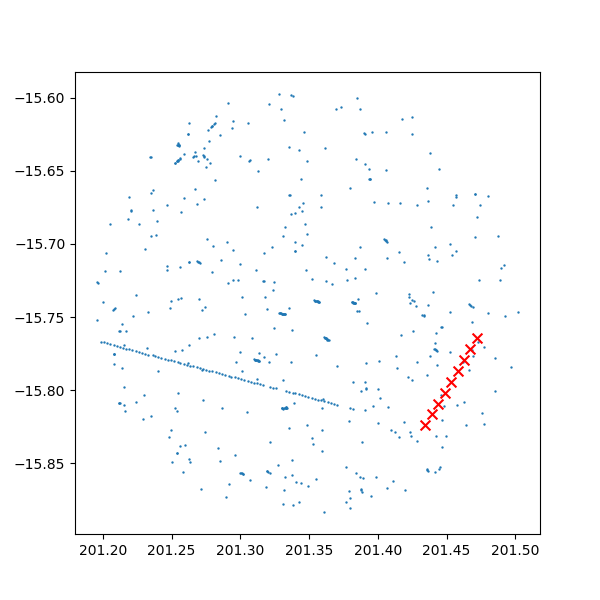

In [294]:
#query from nsc measurements list-----------------------------------------------------------------------------------
dat=qc.query(token,sql='select * from nsc_dr1.meas where q3c_radial_query(ra,dec,201.35,-15.74,.15)',fmt='table')
X=np.column_stack((np.array(dat['ra']),np.array(dat['dec'])))  #X is my set of coordinates--------------------------
#X=np.column_stack((rat,dect))
db = DBSCAN(eps=0.000138889, min_samples=2).fit(X)  #eps= 0.000138889 degrees and min_samples= 2  
ooutliers=db.labels_==-1
plt.figure(figsize=(6,6))
plt.scatter(dat['ra'][ooutliers],dat['dec'][ooutliers],s=0.5)
plt.scatter(jj[0],jj[1],c='red',s=50,marker='x')
plt.show()

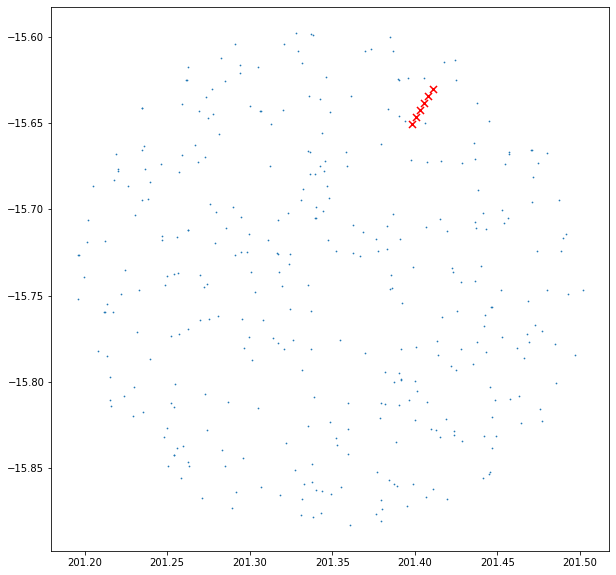

In [98]:
X_out=np.column_stack((np.array(dat[ooutliers]['ra']),np.array(dat[ooutliers]['dec']))) #coordinates of DBSCAN outliers
#X_out=np.column_stack((rat[ooutliers],dect[ooutliers]))
#--------------------
# Tracklet Formation 
#--------------------
#Compute DBSCAN on outliers ------------------------------------------------------------------------------------------
db_2 = DBSCAN(eps=.003, min_samples=3).fit(X_out) #min_samples=3 so at least 3 mmts in a tracklet, to cluster FMOs
outliers=db_2.labels_==-1
plt.figure(figsize=(10,10))
#dato_ra=rat[ooutliers]
#dato_dec=dect[ooutliers]
#plt.scatter(dato[outliers]['ra'],dato[outliers]['dec'],s=0.5)
plt.scatter(dat[ooutliers]['ra'][outliers],dat[ooutliers]['dec'][outliers],s=0.5)
plt.scatter
plt.scatter(jj[0],jj[1],c='red',s=50,marker='x')
#plt.scatter(ave_ra,ave_dec,s=20,c="yellow") #to make sure I have the correct center coordinates
plt.show()

# An attempt at modifying somebody elses's code to make it work for data points instead of images (it sucks)

In [126]:
def hough_line(table):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))  #the degrees we rotate through.  180 of them.
    #i need to quantize the space that I'm looking at.  I'll for now divide the space into 100*100 intervals
    #width = max(table['ra'])-min(table['ra'])*100 #change this to be more meaningful
    #height = max(table['dec'])-min(table['dec'])*100#dif between min and max dec
    width=100.0
    height=100.0
    x_sp=(max(table['ra'])-min(table['ra']))/100.0 #size of each cell in RA (cell width)
    y_sp=(max(table['dec'])-min(table['dec']))/100.0 #size of each cell in Dec (cell height)
    diag_len = np.ceil(np.sqrt(width * width + height * height))  # max_dist (diagonal length of a rectangular image)
    rhos = np.linspace(-diag_len, diag_len, diag_len*2.0) #the radius to the line that we rotate thruogh the thetas
    
    # Cache some resuable values, for ease later 
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas) #there are 180 thetas that we'll rotate through 

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * int(diag_len), int(num_thetas)))
    #print("shape",np.shape(accumulator)) # dimensions should be = 2 x (# of grid cells), but I think here it's (# of grid cells) x (# of thetas?)
    #y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges
    y_idxs = table['dec']  #coordinates of measurements 
    x_idxs = table['ra']
    ##########xx=np.interp(x_idxs, (x_idxs.min(), x_idxs.max()), (-1, +1))
    ##########yy=np.interp(y_idxs, (y_idxs.min(), y_idxs.max()), (-1, +1))

              
#For every data point, go through every theta and calculate the corresponding rho.                           
    # Vote in the hough accumulator
    for i in tqdm_notebook(range(len(x_idxs)),desc="progress bar"):
        x = x_idxs[i]
        y = y_idxs[i]   #an (RA,Dec) coordinate.  I need to translate this to my grid. 

        for t_idx in range(num_thetas): #for each angle that we rotate through 
            # Calculate rho. diag_len is added for a positive index
            cell_ra=(x-np.mean(table['ra']))/x_sp
            cell_dec=(y-np.mean(table['dec']))/y_sp
            rho = round((((cell_ra-width/2.0) * cos_t[t_idx] + (cell_dec-height/2.0) * sin_t[t_idx])))+diag_len #fix!  it has to calc the dif. btw. center and x,y
            accumulator[int(rho), int(t_idx)] += 1 #what is this?
                

    return accumulator, thetas, rhos

In [163]:
accumulator, thetas, rhos = hough_line(dato[outliers])
# Easiest peak finding based on max votes
idx = np.argmax(accumulator)
print(idx)
rho = rhos[int(idx / accumulator.shape[1])]
print(accumulator.shape[1])
theta = thetas[idx % accumulator.shape[1]]
print("rho={0:.2f}, theta={1:.0f}".format(rho, np.rad2deg(theta)))


22032
180
rho=-19.57, theta=-18


now isolate the maxima, and see for each theta which rho it corresponds to.

# Original Hough Transform code

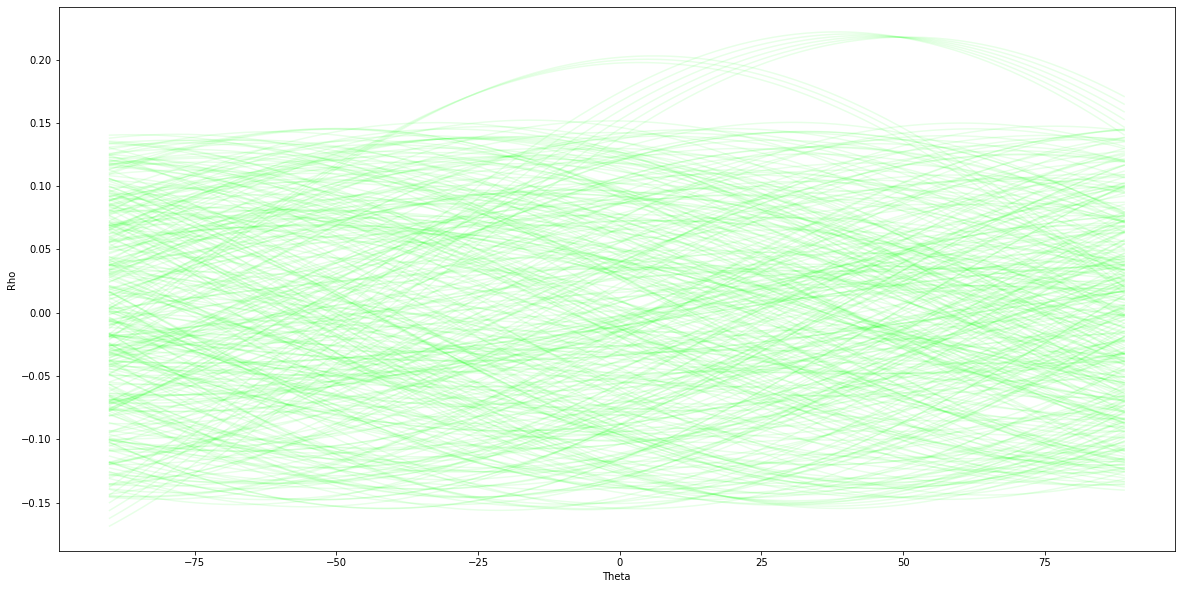

In [216]:
dtab=dat[ooutliers][outliers]

ras=[*np.array(dtab['ra']),*j1[0],*j2[0],*j3[0],*j4[0]]
decs=[*np.array(dtab['dec']),*j1[1],*j2[1],*j3[1],*j4[1]]
times=[*np.array(dtab['mjd']),*j1[2],*j2[2],*j3[2],*j4[2]]
ids=[*np.array(dtab['measid']),*j1[3],*j2[3],*j3[3],*j4[3]]

#ras=[*np.array(dato_ra[outliers]),*jj[0]]
#decs=[*np.array(dato_dec[outliers]),*jj[1]]
angles=np.deg2rad(np.arange(-90.0,90.0))
plt.figure(figsize=(20,10))
min_ra=min(ras)
max_ra=max(ras)
min_dec=min(decs)
max_dec=max(decs)
ave_ra=statistics.mean(ras)
ave_dec=statistics.mean(decs)
grid=(len(dtab)+len(jj[1]))*10
width=1000 #1000 for rad.0.05
height=1000
x_sp=(max_ra-min_ra)/width #size of each cell in RA (cell width)
y_sp=(max_dec-min_dec)/height #size of each cell in Dec (cell height)
diag_len = np.ceil(np.sqrt(width * width + height * height))  
acc=np.zeros((int(2.0*diag_len),len(angles)),dtype=np.uint64)
test=np.zeros((len(angles),len(ras)))
for i in range(0,len(ras)):
    x=ras[i]
    y=decs[i]
    cell_ra=(x-ave_ra)/x_sp
    cell_dec=(y-ave_dec)/y_sp
    #print(cell_ra,cell_dec)
    rhos=[]
    for j in range(0,len(angles)):
        k=np.arange(-90.0,90.0)[j]
        m=angles[j]
        rho = ((x-(ave_ra)) * np.cos(m) + (y-ave_dec) * np.sin(m))
        cell_rho=round((cell_ra-width/2.0) * np.cos(m) + (cell_dec-height/2.0) * np.sin(m))+diag_len
        rhos.append(rho)
        #print(rho,cell_rho)
        acc[int(cell_rho),int(k)+90]+=1
        test[j,i]=cell_rho
    plt.plot(np.arange(-90.0,90.0),rhos,c=[0.1,1,0.1,0.1])
plt.xlabel('Theta')
plt.ylabel('Rho')
plt.show()

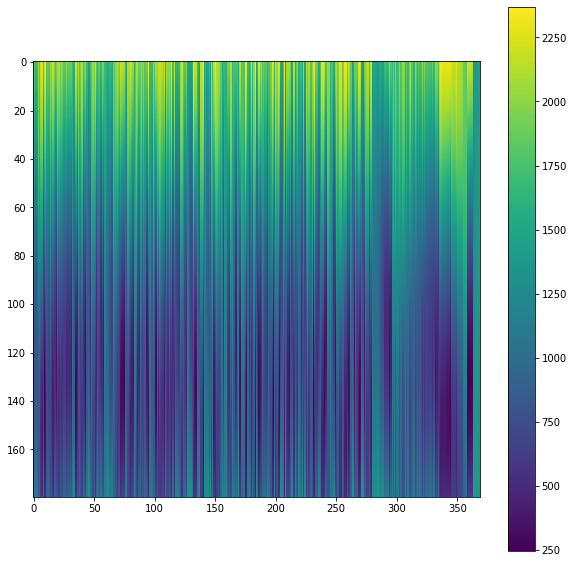

In [217]:
plt.figure(figsize=(10,10))
plt.imshow(test,aspect=2)
plt.colorbar()
plt.show()

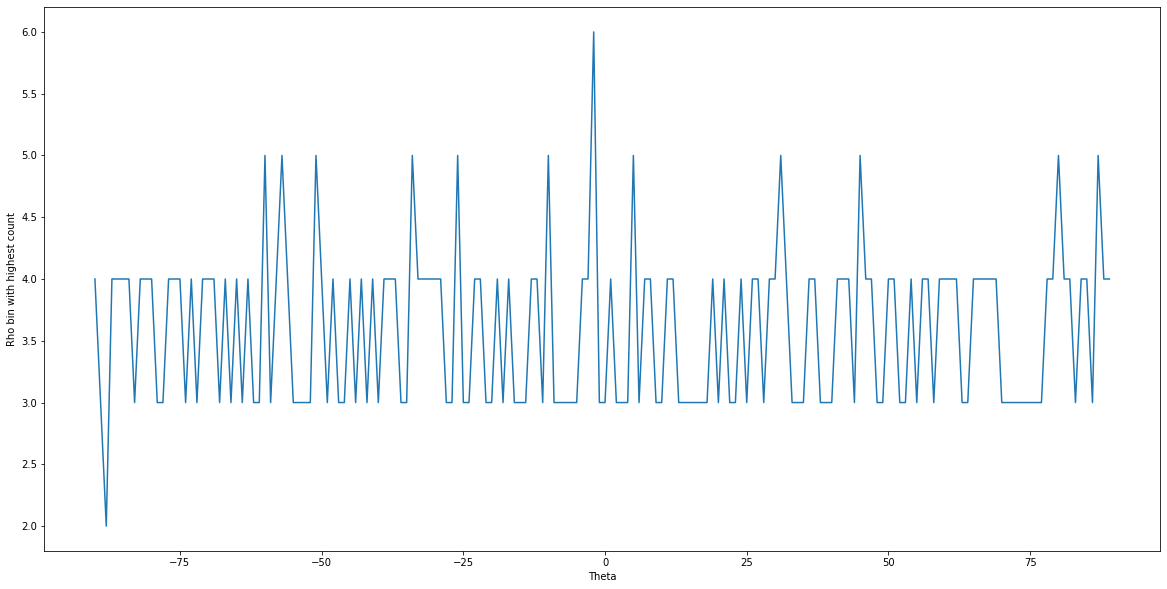

In [284]:
plt.figure(figsize=(20,10))
maxes=[]
vals=[] #angle index
inds=[] #rho index
#for i in tqdm_notebook(np.array(acc).T,desc="progress"):
for i in tqdm_notebook(range(0,len(acc.T)),desc="progress"):
    mm=max(acc.T[i])
    maxes.append(mm)
    #vals.append(list(i).index(mm))
    vals.append(i)
    inds.append(list(acc.T[i]).index(mm))
    
    
plt.plot(np.arange(-90.0,90.0), maxes)
plt.xlabel("Theta")
plt.ylabel("Rho bin with highest count")
plt.show()

<IPython.core.display.Javascript object>


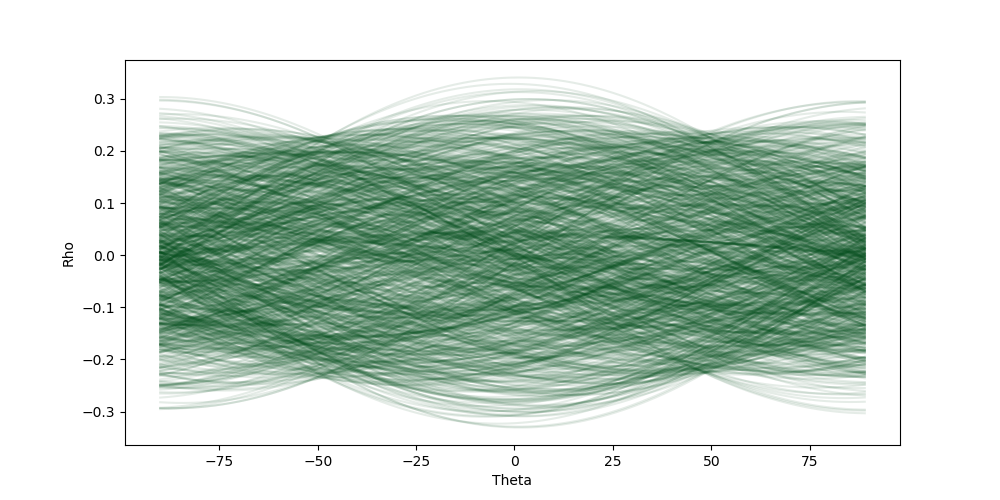

In [308]:
htab_ra=dato_ra[doutliers]
htab_dec=dato_dec[doutliers]
htab_time=dates[dooutliers][doutliers]
htab_ids=ids[dooutliers][doutliers]
ras=[*np.array(htab_ra),*j1[0],*j2[0],*j3[0],*j4[0]]
decs=[*np.array(htab_dec),*j1[1],*j2[1],*j3[1],*j4[1]]
times=[*np.array(htab_time),*j1[2],*j2[2],*j3[2],*j4[2]]
mids=[*np.array(htab_ids),*j1[3],*j2[3],*j3[3],*j4[3]]
angles=np.deg2rad(np.arange(-90.0,90.0))
plt.figure(figsize=(10,5))
min_ra=min(ras)
max_ra=max(ras)
min_dec=min(decs)
max_dec=max(decs)
ave_ra=statistics.mean(ras)
ave_dec=statistics.mean(decs)
grid=(len(ras))*10
width=500 #1000 for rad.0.05
height=500 #5000 for nice test array pic
x_sp=(max_ra-min_ra)/width #size of each cell in RA (cell width)
y_sp=(max_dec-min_dec)/height #size of each cell in Dec (cell height)
diag_len = np.ceil(np.sqrt(width * width + height * height))  
acc=np.zeros((int(2.0*diag_len),len(angles)),dtype=np.uint64)
acc_sec=np.zeros((int(2.0*diag_len),len(angles)),dtype=np.str)
test=np.zeros((len(angles),len(ras)))
for i in range(0,len(ras)):
    x=ras[i]
    y=decs[i]
    cell_ra=(x-ave_ra)/x_sp
    cell_dec=(y-ave_dec)/y_sp
    #print(cell_ra,cell_dec)
    rhos=[]
    for j in range(0,len(angles)):
        k=np.arange(-90.0,90.0)[j]
        m=angles[j]
        rho = ((x-(ave_ra)) * np.cos(m) + (y-ave_dec) * np.sin(m)) #radius in (ra,dec)
        cell_rho=round((cell_ra-width/2.0) * np.cos(m) + (cell_dec-height/2.0) * np.sin(m))+diag_len #(radius in grid counts)
        rhos.append(rho)
        acc[int(cell_rho),int(k)+90]+=1
        test[j,i]=rho #or rho
        
    plt.plot(np.arange(-90.0,90.0),rhos,c=[0,0.3,0.1,0.1])
plt.xlabel('Theta')
plt.ylabel('Rho')
plt.show()

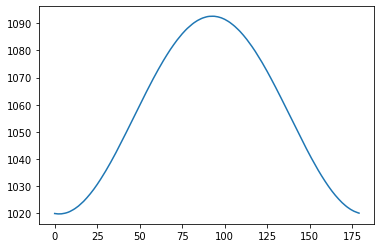

In [249]:
stds=[]
for ii in range(0,len(test)):
    stds.append(np.std(test[ii]))
    
plt.plot(stds)
plt.show()

<IPython.core.display.Javascript object>


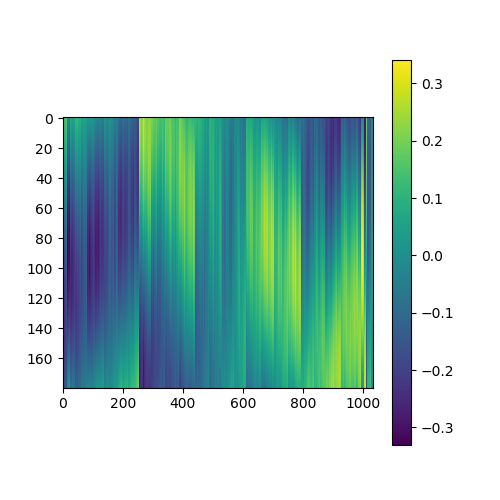

In [300]:
plt.figure(figsize=(5,5))
plt.imshow(test,aspect=5)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


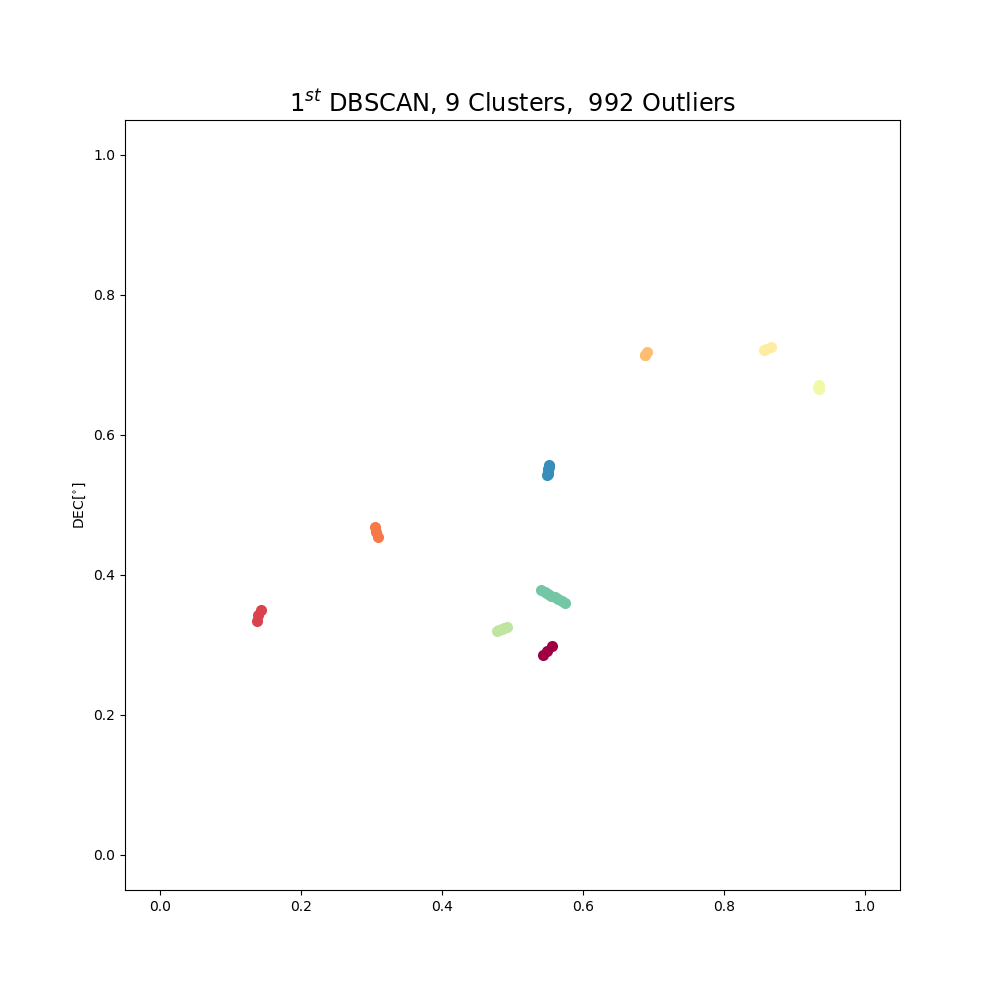

<IPython.core.display.Javascript object>


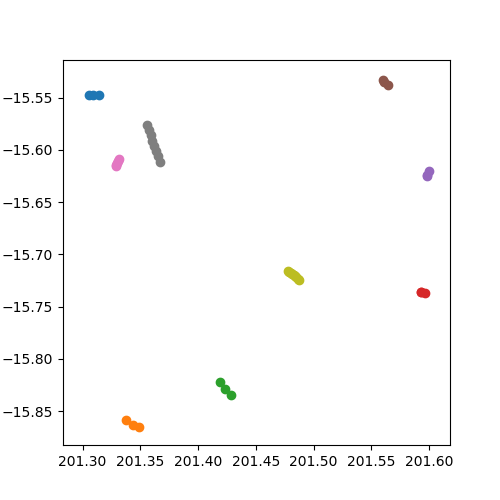

In [305]:
theta=-45

#normalize data
tnorm=(times-min(times))/(max(times)-min(times))*5*100
rhonorm=(test[theta]-min(test[theta]))/(max(test[theta])-min(test[theta]))
ranorm=(ras-min(ras))/(max(ras)-min(ras))
decnorm=(decs-min(decs))/(max(decs)-min(decs))

#dbscan 
ss=np.column_stack((rhonorm,ranorm,tnorm)) #you need to do more than just normalization - you need to do some relative scaling or something.  RA,Ded,Rho on same page
dscan=DBSCAN(eps=0.01, min_samples=3).fit(ss)
plot_dbscan(ss,dscan,plt)
plt.show()

plt.figure(figsize=(5,5))
for ii in np.unique(dscan.labels_):
    good=dscan.labels_==ii
    if ii!=-1:
        plt.scatter(np.array(ras)[good],np.array(decs)[good])
##plt.xlim(201.39,201.42)
#plt.ylim(56833.0,56833.1)
##plt.ylim(-15.6,-15.2)
plt.show()
    #some are so far away from each other....i think i tried standard deviation 
    #but you really need more points to do so....

<IPython.core.display.Javascript object>


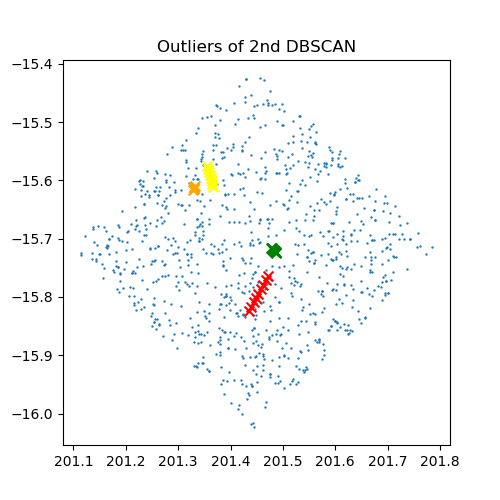

In [304]:
X_out=np.column_stack((rat[dooutliers],dect[dooutliers]))
#--------------------
# Tracklet Formation 
#--------------------
#Compute DBSCAN on outliers ------------------------------------------------------------------------------------------
db_2 = DBSCAN(eps=.003, min_samples=3).fit(X_out) #min_samples=3 so at least 3 mmts in a tracklet, to cluster FMOs
doutliers=db_2.labels_==-1
plt.figure(figsize=(5,5))
dato_ra=rat[dooutliers]
dato_dec=dect[dooutliers]
plt.scatter(dato_ra[doutliers],dato_dec[doutliers],s=0.5)
plt.title("Outliers of 2nd DBSCAN")
#plt.scatter(dat[ooutliers]['ra'][outliers],dat[ooutliers]['dec'][outliers],s=0.5)
plt.scatter(jj[0],jj[1],c='red',s=50,marker='x')
plt.scatter(j2[0],j2[1],c='orange',s=50,marker='x')
plt.scatter(j3[0],j3[1],c='yellow',s=50,marker='x')
plt.scatter(j4[0],j4[1],c='green',s=50,marker='x')
plt.plot()################################################plot the line 
#plt.scatter(ave_ra,ave_dec,s=20,c="yellow") #to make sure I have the correct center coordinates
plt.show()

In [117]:
test[34,-6:] #these are the rhos for jj tracklet mmts., for theta=34, grid=1000, small section of sky : [1377., 1370., 1363., 1356., 1349., 1341.]

array([1377., 1370., 1363., 1356., 1349., 1341.])

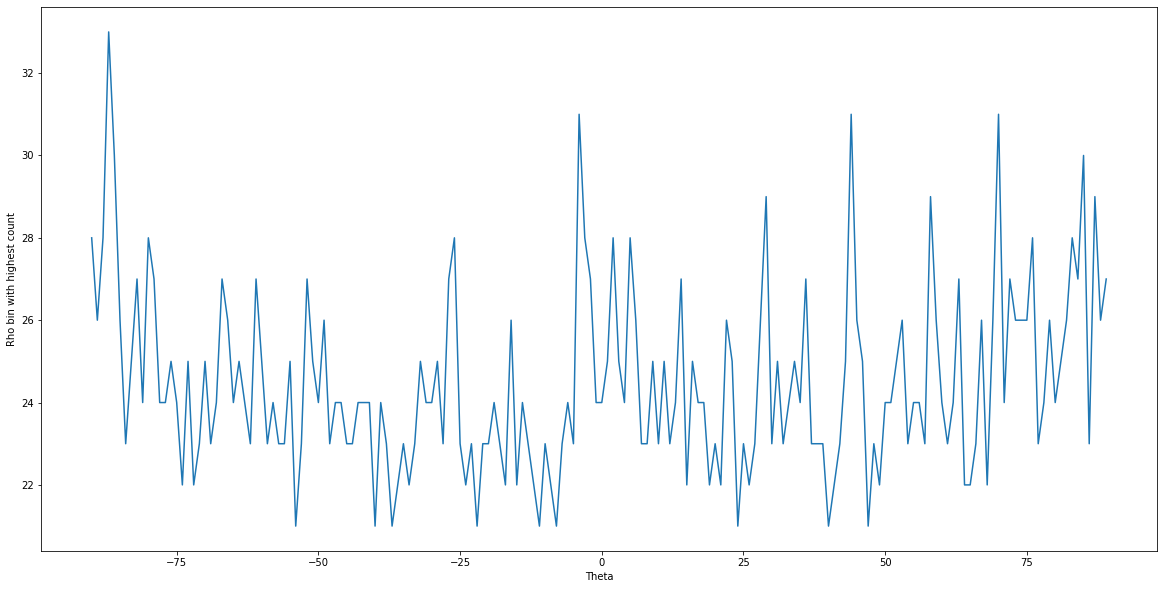

In [66]:
plt.figure(figsize=(20,10))
maxes=[]
vals=[] #angle index
inds=[] #rho index
#for i in tqdm_notebook(np.array(acc).T,desc="progress"):
for i in tqdm_notebook(range(0,len(acc.T)),desc="progress"):
    mm=max(acc.T[i])
    maxes.append(mm)
    #vals.append(list(i).index(mm))
    vals.append(i)
    inds.append(list(acc.T[i]).index(mm))
    
    
plt.plot(np.arange(-90.0,90.0), maxes)
plt.xlabel("Theta")
plt.ylabel("Rho bin with highest count")
plt.show()

In [378]:
m=max(maxes)
ii=maxes.index(m)
print(angles[ii],vals[ii],inds[ii])

0.20943951023931956 102 1573


In [380]:
acc[1573,102]

9

angle in rad is 0.2094, rho in cell_space is 1573

### The problem here is that there are too many points.  It's too noisy, and it's hard to get the right number of bins. 

I think cross-matching SOs from a catalog of known objects instead of using DBSCAN will help...... but what catalog?

In [344]:
len(vals)

180

# Figuring out how to get local maxima from the accumulator array

In [37]:
#this one sucks
from scipy.signal import argrelextrema
# for local maxima
j=argrelextrema(acc.T[100], np.greater)

In [38]:
from scipy.signal import find_peaks
#peaks, _ = 
k=find_peaks(acc.T[100], height=3)
acc.T[100][k[0]]

array([4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3], dtype=uint64)

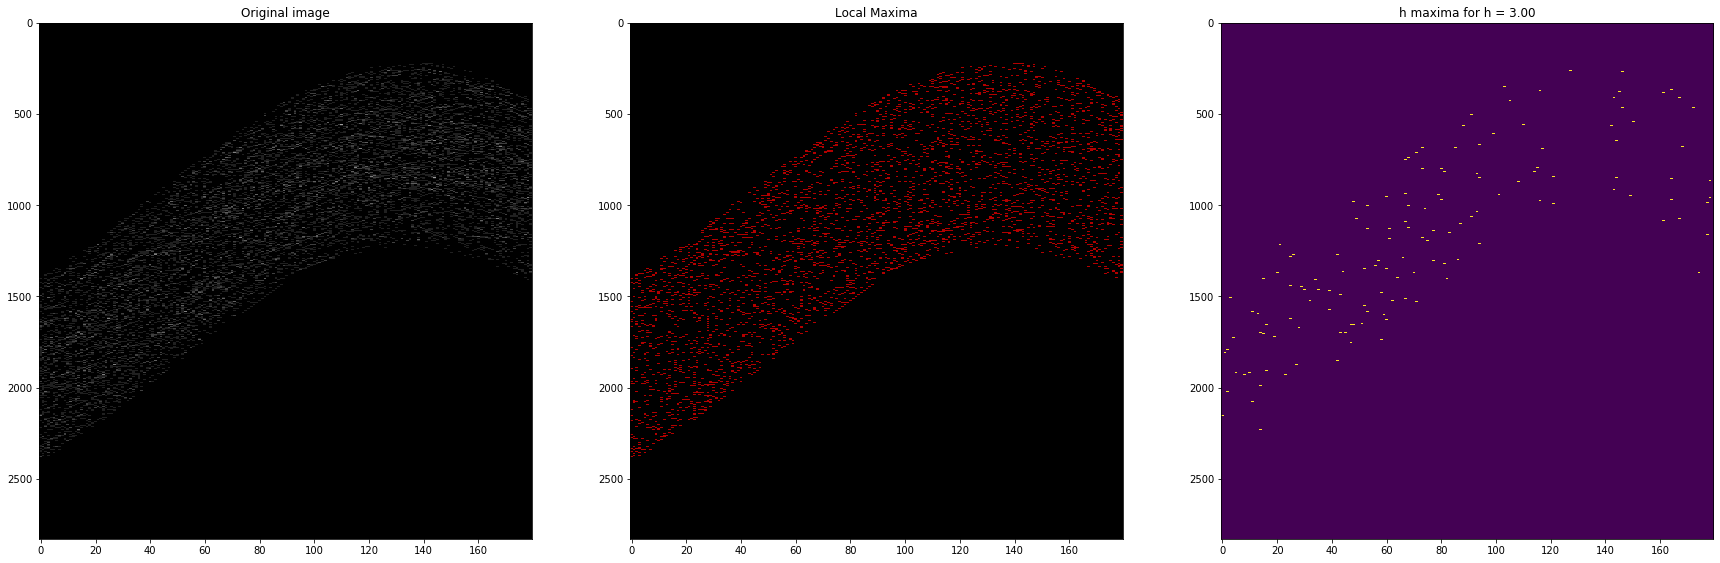

In [206]:
from skimage.measure import label
from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure


img=acc

# Maxima in the galaxy image are detected by mathematical morphology.
# There is no a priori constraint on the density.

# We find all local maxima
local_maxima = extrema.local_maxima(img)
label_maxima = label(local_maxima)
overlay = color.label2rgb(label_maxima, img, alpha=0.7, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])

# We observed in the previous image, that there are many local maxima
# that are caused by the noise in the image.
# For this, we find all local maxima with a height of h.
# This height is the gray level value by which we need to descent
# in order to reach a higher maximum and it can be seen as a local
# contrast measurement.
# The value of h scales with the dynamic range of the image, i.e.
# if we multiply the image with a constant, we need to multiply
# the value of h with the same constant in order to achieve the same result.
h = 3
h_maxima = extrema.h_maxima(img, h)
label_h_maxima = label(h_maxima)
overlay_h = color.label2rgb(label_h_maxima, img, alpha=0.7, bg_label=0,
                            bg_color=None, colors=[(1, 0, 0)])


# a new figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].imshow(img, cmap='gray',aspect=1/15.0)
ax[0].set_title('Original image')
#ax[0].axis('off')

ax[1].imshow(overlay,aspect=1/15.0)
ax[1].set_title('Local Maxima')
#ax[1].axis('off')

ax[2].imshow(h_maxima,aspect=1/15.0)#
ax[2].set_title('h maxima for h = %.2f' % h)
#ax[2].axis('off')
plt.show()

In [151]:
ch=np.nonzero(h_maxima) #indices of the maxima 
len(ch[0])

1841

In [150]:
print(ch[0][0],ch[1][0])

1780 135


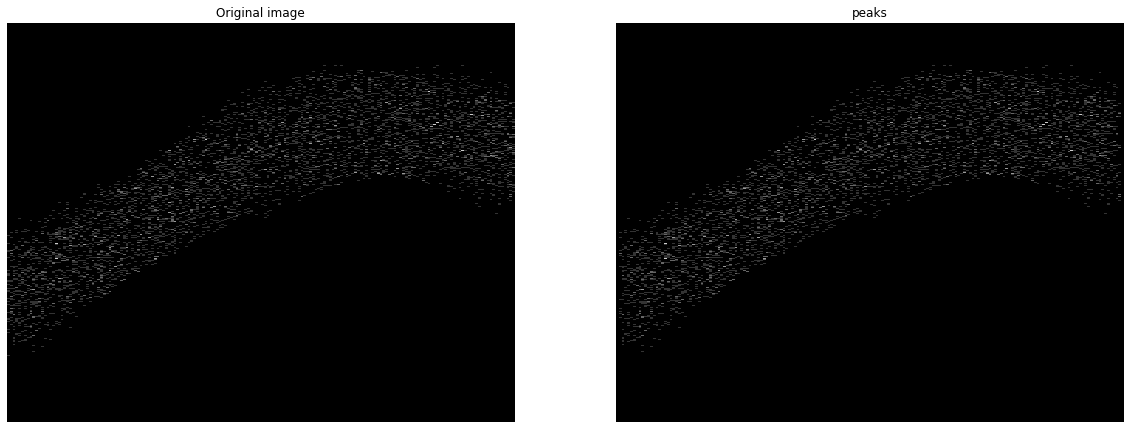

In [78]:
from skimage import data
from skimage.exposure import rescale_intensity
from skimage.morphology import reconstruction

#Alternatively, we can find bright spots in an image using morphological reconstruction by dilation. Dilation is the inverse of erosion and expands the maximal values of the seed image until it encounters a mask image. Since this is an inverse operation, we initialize the seed image to the minimum image intensity instead of the maximum. The remainder of the process is the same.
image=acc
mask=acc
seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
rec = reconstruction(seed, mask, method='dilation')

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image, cmap='gray',aspect=1/100.0)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(image-rec, cmap='gray',aspect=1/100.0)
ax[1].set_title('peaks')
ax[1].axis('off')
plt.show()

In [58]:
np.shape(rec)

(14144, 180)

In [59]:
np.shape(image)

(14144, 180)

In [72]:
rec.max()

4.0

<function matplotlib.pyplot.show(*args, **kw)>

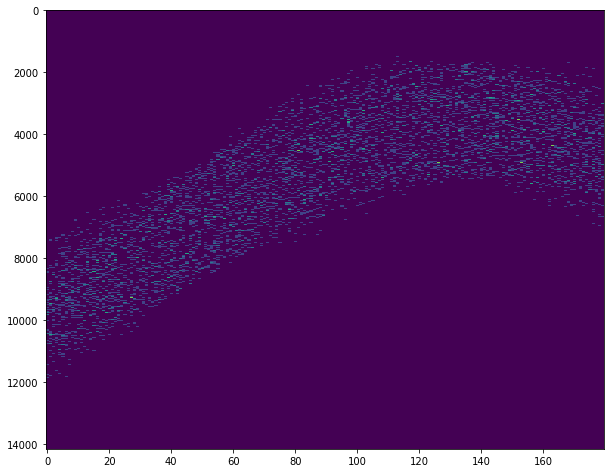

In [80]:
plt.figure(figsize=(10,10))
plt.imshow(img,aspect=1/100.0)
plt.show

# Overplot detected lines

In [278]:
thet=45
rh=0.05
xras=np.linspace(min(ra),max(ra),10)
ydecs=-(np.cos(thet.degree)/np.sin(thet.degree))*xras+rh/np.sin(thet.degree)

NameError: name 'ra' is not defined